# TIME SERIES FORECASTING OF CRUDE OIL PRICES

**Author:** [Igemhokhai Shedrach](https://www.linkedin.com/igemhokhai-shedrach-60982819a)

Time series forecasting is a technique for the prediction of events through a sequence of time. The technique is used across many fields of study, from the geology to behavior to economics. The techniques predict future events by analyzing the trends of the past, on the assumption that future trends will hold similar to historical trends.

**Goals of this Project :**
#### Used Machine Learning to Build a time series forecasting model of Crude Oil Prices using Two Models :
- AutoReg
- ARIMA

**Source of Data :**
For this project, data from [The U.S Energy Information Administration]("www.eia.gov") was used, The Website "www.eia.gov" contains the price of Natural gas from 1994 till date(imputed daily)

#### Importing Required Libraries

In [134]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import warnings
warnings.filterwarnings(action="ignore")

#### Loading Data into a Pandas DataFrame

In [31]:
df=pd.read_csv(r"C:\Users\User\Desktop\Machine Learning Project\Time Series\Cushing_OK_Crude_Oil_Future_Contract_1.csv",
              skiprows=range(4))
df.head()

Day  Cushing OK Crude Oil Future Contract 1  Dollars per Barrel
0  08/16/2022                                              86.53         
1  08/15/2022                                              89.41         
2  08/12/2022                                              92.09         
3  08/11/2022                                              94.34         
4  08/10/2022                                              91.93

#### Analysis and Wrangling of Data

In [32]:
df.columns

Index(['Day', 'Cushing OK Crude Oil Future Contract 1  Dollars per Barrel'], dtype='object')

In [33]:
df["oil_price"]=df['Cushing OK Crude Oil Future Contract 1  Dollars per Barrel']
df.drop(columns='Cushing OK Crude Oil Future Contract 1  Dollars per Barrel', inplace=True)
df.head()

Day  oil_price
0  08/16/2022      86.53
1  08/15/2022      89.41
2  08/12/2022      92.09
3  08/11/2022      94.34
4  08/10/2022      91.93

In [34]:
print("shape :",df.shape)
df.info()

shape : (9886, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9886 entries, 0 to 9885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Day        9886 non-null   object 
 1   oil_price  9886 non-null   float64
dtypes: float64(1), object(1)
memory usage: 154.6+ KB


- Convert the "Day" column to a Datetime format, since we are dealing with time series

In [35]:
df["Day"]=pd.to_datetime(df["Day"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9886 entries, 0 to 9885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Day        9886 non-null   datetime64[ns]
 1   oil_price  9886 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 154.6 KB


- As seen in the data frame above, the order of the Date column was from recent date to old date. we would now reorder it to start from oldest to recent date.

In [36]:
df1=df.reindex(index=df.index[::-1])
df1=df1.set_index("Day")
df1.head(20)

oil_price
Day                  
1983-04-04      29.44
1983-04-05      29.71
1983-04-06      29.92
1983-04-07      30.17
1983-04-08      30.38
1983-04-11      30.26
1983-04-12      30.83
1983-04-13      30.82
1983-04-14      30.67
1983-04-15      30.48
1983-04-18      30.75
1983-04-19      30.75
1983-04-20      30.70
1983-04-21      30.68
1983-04-22      30.75
1983-04-25      30.84
1983-04-26      30.71
1983-04-27      30.78
1983-04-28      30.74
1983-04-29      30.63

In [37]:
df1.describe()

oil_price
count  9886.000000
mean     44.606901
std      28.756238
min     -37.630000
25%      20.260000
50%      31.280000
75%      63.595000
max     145.290000

- Lets see if our data contains negative values

In [38]:
(df1["oil_price"]<0).value_counts()

False    9885
True        1
Name: oil_price, dtype: int64

- Since we've found out that our data contains just one negative values in a data of about 10,000 rows, we would drop that value

In [39]:
df1=df1[df1["oil_price"]>0]

In [40]:
(df1["oil_price"]<0).value_counts()

False    9885
Name: oil_price, dtype: int64

- Our data is missing some days and since Time Series Forecasting Requires a data with a constant frequency, we would now convert the frequency of the data to a daily frequency.

In [41]:
df1=df1.asfreq(pd.infer_freq(df1.index))
df1.head(20)

oil_price
Day                  
1983-04-04      29.44
1983-04-05      29.71
1983-04-06      29.92
1983-04-07      30.17
1983-04-08      30.38
1983-04-09        NaN
1983-04-10        NaN
1983-04-11      30.26
1983-04-12      30.83
1983-04-13      30.82
1983-04-14      30.67
1983-04-15      30.48
1983-04-16        NaN
1983-04-17        NaN
1983-04-18      30.75
1983-04-19      30.75
1983-04-20      30.70
1983-04-21      30.68
1983-04-22      30.75
1983-04-23        NaN

- The Setting of the frequency of our data to daily resulted in rows with NaNs. we would fill those rows using a forward fill technique i.e data from the previous row is imputed in the next row with missing values.

In [42]:
df1["oil_price"]=df1["oil_price"].ffill()
df1.head(20)

oil_price
Day                  
1983-04-04      29.44
1983-04-05      29.71
1983-04-06      29.92
1983-04-07      30.17
1983-04-08      30.38
1983-04-09      30.38
1983-04-10      30.38
1983-04-11      30.26
1983-04-12      30.83
1983-04-13      30.82
1983-04-14      30.67
1983-04-15      30.48
1983-04-16      30.48
1983-04-17      30.48
1983-04-18      30.75
1983-04-19      30.75
1983-04-20      30.70
1983-04-21      30.68
1983-04-22      30.75
1983-04-23      30.75

- Next, lets see how the values in our data is distributed.

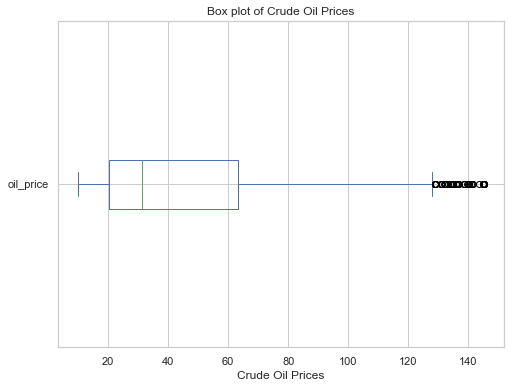

In [43]:
df1.plot(kind='box',vert=False, figsize=(8, 6))
plt.title('Box plot of Crude Oil Prices')
plt.xlabel('Crude Oil Prices')
plt.show()

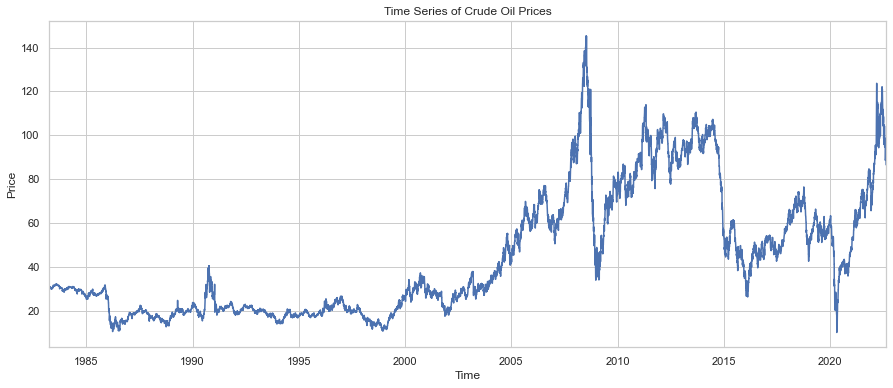

In [44]:
fig,ax=plt.subplots(figsize=(15,6))
df1["oil_price"].plot(ax=ax, xlabel="Time",ylabel="Price",title="Time Series of Crude Oil Prices");

#### Lets see if our data Contains Trends and Seasonality, usimg Statsmodel's seasonal_decompose

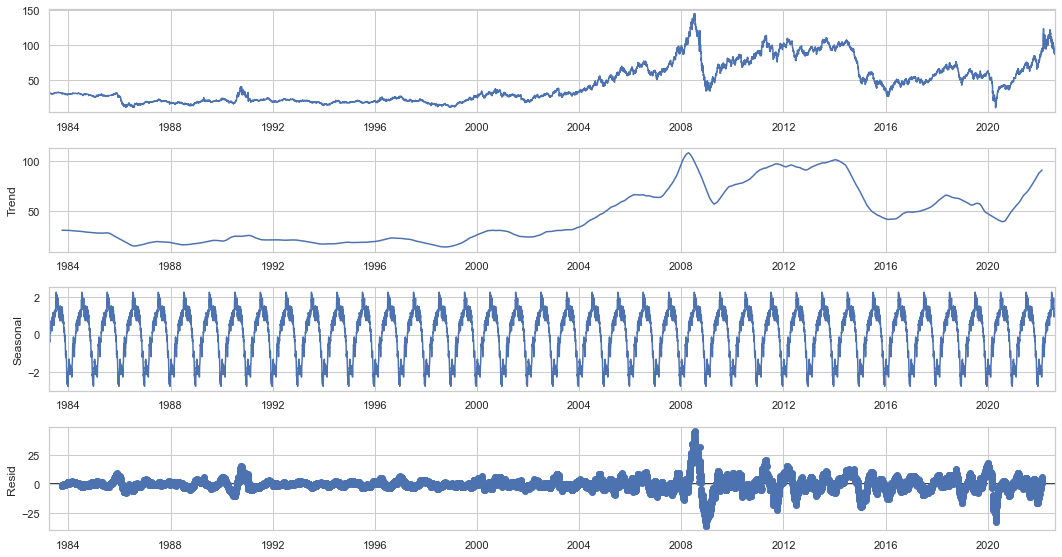

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc("figure",figsize=(15,8))
plt.rc("font", size=15)
result=seasonal_decompose(df1,model="additive", period=365)
fig=result.plot()

#### We would now create an ACF and PACF plot to see how well the present values of our Series is Related with its past values

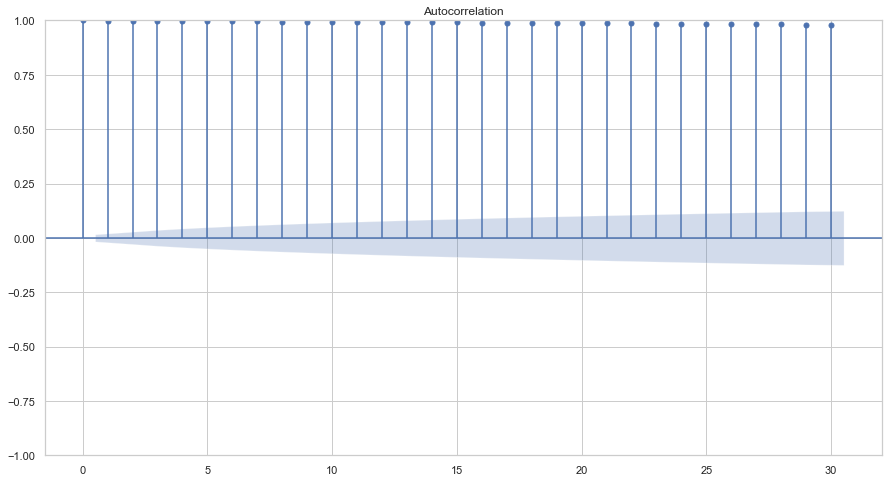

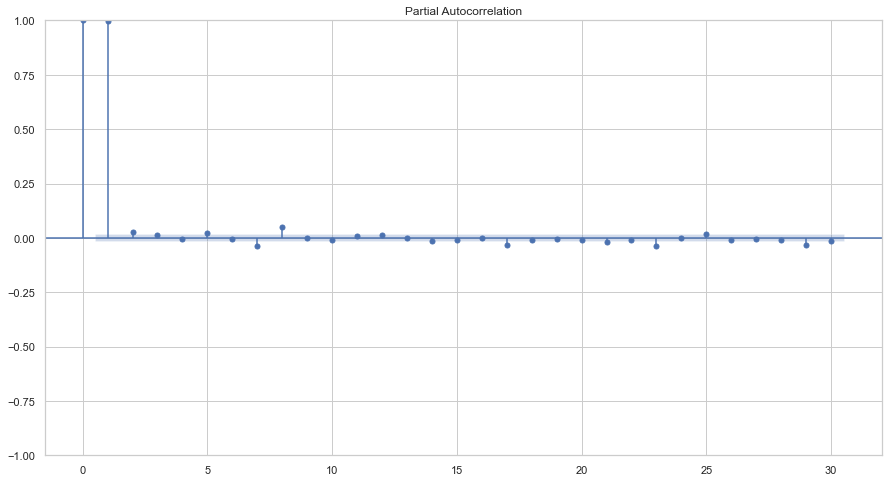

In [46]:
fig1=plot_acf(df1,lags=30)
fig2=plot_pacf(df1, lags=30)
fig1.show()

- We can see from the ACF plot, that The previous data(up to 30 days) has some strong correlation with the present Value, while the PACF plot(Which is a more important factor) shows that the previous two lags have the strongest correlation.

#### Splitting of data into train and test set.

In [47]:
cutoff=int(len(df1["oil_price"])*0.9)
train=df1["oil_price"].iloc[:cutoff]
test=df1["oil_price"].iloc[cutoff:]
print("Shape of Training Data :", train.shape)
print("Shape of Test Data :", test.shape)

Shape of Training Data : (12942,)
Shape of Test Data : (1438,)


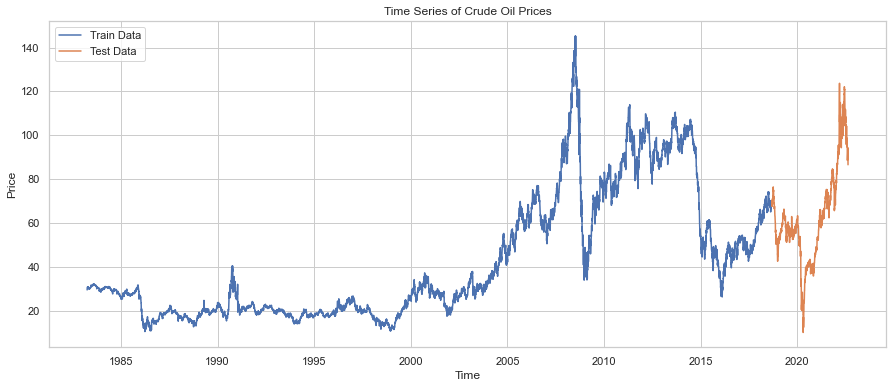

In [48]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title("Time Series of Crude Oil Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["Train Data", "Test Data"],loc="upper left");

#### Lets create a baseline for our model. A good Performing model must beat the baseline.

In [49]:
train_mean=train.mean()
train_pred_baseline=[train_mean]*len(train)
train_mae=mean_absolute_error(train,train_pred_baseline)
print("Mean Natural Gas Prices: ", train_mean)
print("Baseline MAE:", train_mae)

Mean Natural Gas Prices:  42.54230026271061
Baseline MAE: 24.218270300543974


# AUTOREG

#### Hyperparameter tuning to determine the optimum number of lags to used for the model building

In [50]:
p_params=range(1,31)
maes=list()
for p in p_params:
    start_time=time.time()
    model=AutoReg(train, lags=p).fit()
    end_time=round(time.time()-start_time,2)
    print(f" Trained Model {p} in {end_time} seconds")
    pred=model.predict().dropna()
    mae=mean_absolute_error(train.iloc[p:],pred)
    maes.append(mae)
    
    pass
mae_series=pd.Series(maes, name="mae", index=p_params)
mae_series.head()

 Trained Model 1 in 0.01 seconds
 Trained Model 2 in 0.0 seconds
 Trained Model 3 in 0.01 seconds
 Trained Model 4 in 0.01 seconds
 Trained Model 5 in 0.01 seconds
 Trained Model 6 in 0.01 seconds
 Trained Model 7 in 0.01 seconds
 Trained Model 8 in 0.01 seconds
 Trained Model 9 in 0.01 seconds
 Trained Model 10 in 0.0 seconds
 Trained Model 11 in 0.02 seconds
 Trained Model 12 in 0.02 seconds
 Trained Model 13 in 0.02 seconds
 Trained Model 14 in 0.02 seconds
 Trained Model 15 in 0.02 seconds
 Trained Model 16 in 0.02 seconds
 Trained Model 17 in 0.02 seconds
 Trained Model 18 in 0.03 seconds
 Trained Model 19 in 0.02 seconds
 Trained Model 20 in 0.01 seconds
 Trained Model 21 in 0.03 seconds
 Trained Model 22 in 0.02 seconds
 Trained Model 23 in 0.02 seconds
 Trained Model 24 in 0.03 seconds
 Trained Model 25 in 0.02 seconds
 Trained Model 26 in 0.03 seconds
 Trained Model 27 in 0.02 seconds
 Trained Model 28 in 0.04 seconds
 Trained Model 29 in 0.03 seconds
 Trained Model 30 in 0.02

1    0.458249
2    0.460810
3    0.461124
4    0.461323
5    0.463913
Name: mae, dtype: float64

In [51]:
mae_series.min()

0.45824947284432027

In [190]:
best_p=mae_series[mae_series==mae_series.min()].index[0]
best_model=AutoReg(train, lags=best_p).fit()

In [191]:
import pickle
with open("AUTOREG-Model(Oil)", "wb") as f :
    pickle.dump(best_model, f)
print("Model Saved")

Model Saved


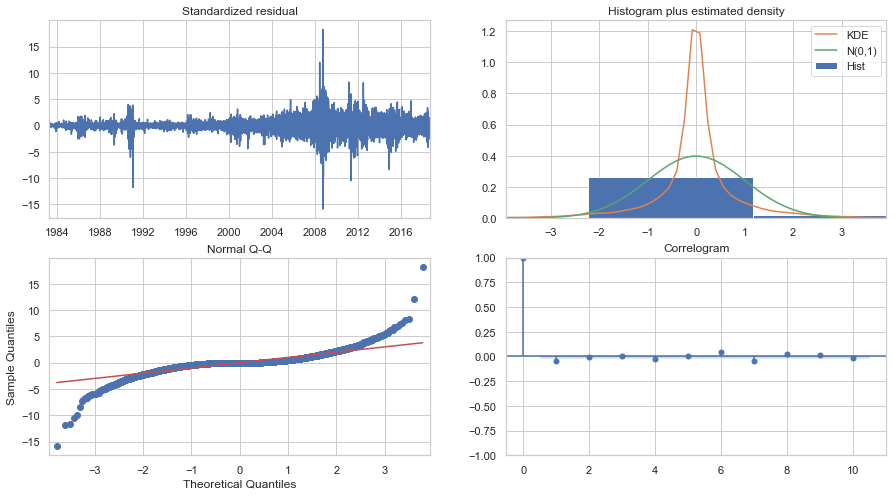

In [58]:
best_model.plot_diagnostics(figsize=(15,8))
plt.show()

- As seen above, the optimum number of lags to be used is 2, as it has the least mean absolute error

#### Next, lets see the Residuals of our Model

In [53]:
train_resid=best_model.resid
train_resid.name="Residuals"
train_resid.head()

Day
1983-04-05    0.260931
1983-04-06    0.201057
1983-04-07    0.241155
1983-04-08    0.201272
1983-04-09   -0.008630
Freq: D, Name: Residuals, dtype: float64

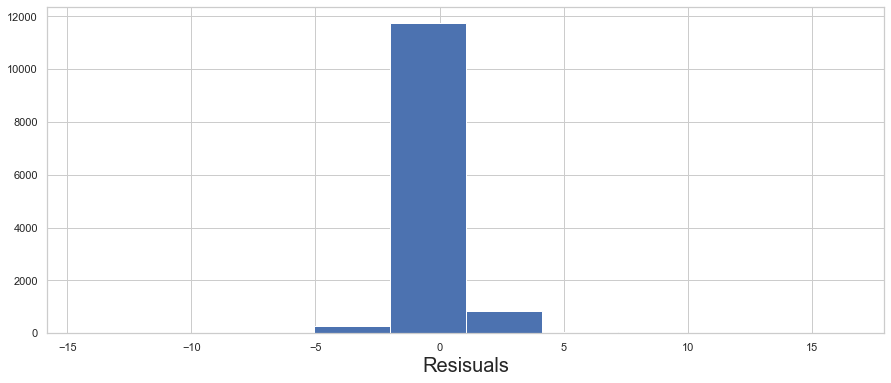

In [54]:
train_resid.hist(figsize=(15,6))
plt.xlabel("Resisuals", fontsize=20);

- The Histogram shows that our Residual errors is normally distributed with mean zero

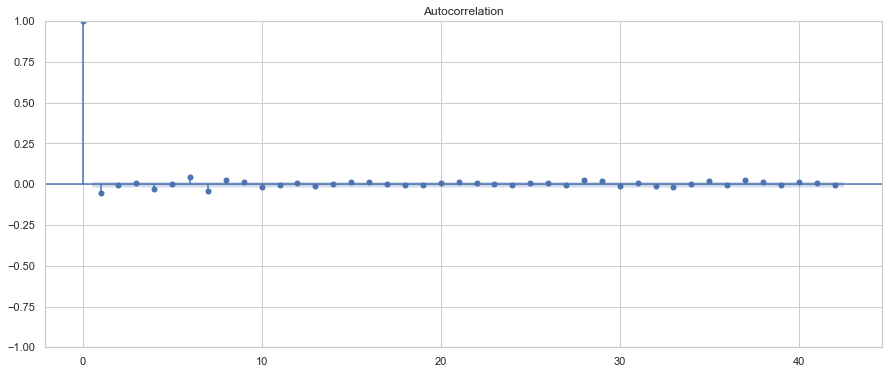

In [55]:
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(train_resid,ax=ax);

#### Next, we would Implement Walk Forward Validation to Forecast predictions on our test set

In [56]:
train_pred_wfv=pd.Series()
history=train.copy()
for i in range(len(test)):
    model1=AutoReg(history, lags=best_p).fit()
    next_pred=model1.forecast()
    train_pred_wfv=train_pred_wfv.append(next_pred)
    history=history.append(test[next_pred.index])
    
    pass
train_pred_wfv.name="Prediction"
train_pred_wfv.index.name="Day"
train_pred_wfv.head()

Day
2018-09-09    67.741206
2018-09-10    67.741207
2018-09-11    67.531277
2018-09-12    69.240719
2018-09-13    70.360367
Freq: D, Name: Prediction, dtype: float64

#### Creating a dataframe of the actual prices and our predicted prices

In [59]:
df_pred_test=pd.DataFrame(
    {"Actual" :test, "Predicted" : train_pred_wfv}, index=test.index
)
df_pred_test.tail(10)

Actual  Predicted
Day                          
2022-08-07   89.01  88.991153
2022-08-08   90.76  88.991158
2022-08-09   90.50  90.740684
2022-08-10   91.93  90.480756
2022-08-11   94.34  91.910393
2022-08-12   92.09  94.319828
2022-08-13   92.09  92.070342
2022-08-14   92.09  92.070348
2022-08-15   89.41  92.070353
2022-08-16   86.53  89.391042

#### Visualising our Actual and Predicted values using Plotly

In [60]:
import plotly.express as px
fig=px.line(df_pred_test, labels={"value":"Crude Oil Price"})
fig.update_layout(
    title="Time Series of Crude Oil Prices - Actual vs Predicted",
    xaxis_title="Date",
    yaxis_title="Price"
)
fig.show()

- As seen in the plot above, our predicted values nearly coincide with the actual values, meaning our model did well in predictions.

#### Next, lets Evaluate our model using the below performance metrics

In [61]:
mse=mean_squared_error(test,train_pred_wfv)
print("MSE: "+str(mse))
mae=mean_absolute_error(test,train_pred_wfv)
print("MAE: "+str(mae))
rmse=math.sqrt(mean_squared_error(test,train_pred_wfv))
print("RMSE: "+str(rmse))
mape=np.mean(np.abs(train_pred_wfv-test)/np.abs(test))
print("MAPE: "+str(mape))

MSE: 2.498246237637675
MAE: 0.8616499165497309
RMSE: 1.5805841444344793
MAPE: 0.015488419564757603


### With a Mean absolute Percentage Error(MAPE) of about 0.015, we can say our model performed great, having an estimated accuracy of about 98.5%

# AUTO REGRESSIVE INTEGRATED MOVING AVERAGE(ARIMA)
#### In order to use ARIMA as our model, it is important that our data is stationary, so there won't be bias in our forecasting. A stationary data is one that has a independent of time. in order words, it has a constant mean and variance over time, and our model need not come up with two many features as a result of a constantly changing trend. Hence, the first step is to test for the stationarity of our data. There are two most common tests for stationarity, viz;
**Augmented Dickey Fuller Test(ADF TEST)** : Using this test, one can only reject the null hypothesis(infer that the data is stationary) if the p-value is less than the significance value of 0.05, and if the test statistics is less than that of the critical values.

**KPSS TEST** : This test is the opposite of the ADF test even if they haave the same aim of testing for stationarity. Using this test, one can only reject the null hypothesis(infer that the data is stationary) if the p-value is greater than the significance value of 0.05, and if the test statistics is greater than that of the critical values.

#### We would start by creating the Tests' Functions

In [62]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest=kpss(timeseries, regression="ct")
    kpss_out=pd.Series(kpsstest[0:3], index=["Test Statistics","p-value", "Lags Used"])
    for key,value in kpsstest[3].items():
        kpss_out["Critical Value (%s)" % key]=value
    print(kpss_out)

In [63]:
def adf_test(timeseries):
    print("Results of ADF test")
    result=adfuller(timeseries)
    print("ADF Statistics : %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [64]:
adf_test(df1["oil_price"])

Results of ADF test
ADF Statistics : -1.994403
p-value: 0.289033
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


- With a p-value greater than 0.05, one can infer that the data is non stationary using the ADF TEST. lets look at the results of the KPSS TEST

In [65]:
kpss_test(df1["oil_price"])

Results of KPSS Test:
Test Statistics           1.304574
p-value                   0.010000
Lags Used                72.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


- With a p-value Less than 0.05, one can infer that the data is non stationary using the KPSS TEST

#### Now that we know, that our data is Non stationary, making it stationary before model implementation is imperative. one way to make it stationary is DIFFERENCING which would be done using the "diff()" function

In [97]:
df_stat=df1["oil_price"].diff().dropna()
df_stat.head()

Day
1983-04-05    0.27
1983-04-06    0.21
1983-04-07    0.25
1983-04-08    0.21
1983-04-09    0.00
Freq: D, Name: oil_price, dtype: float64

In [98]:
adf_test(df_stat)

Results of ADF test
ADF Statistics : -19.802922
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [99]:
kpss_test(df_stat)

Results of KPSS Test:
Test Statistics           0.038137
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


- We can conclude from both tests above, that a first order differing(d=1) would make our data stationaty.¶

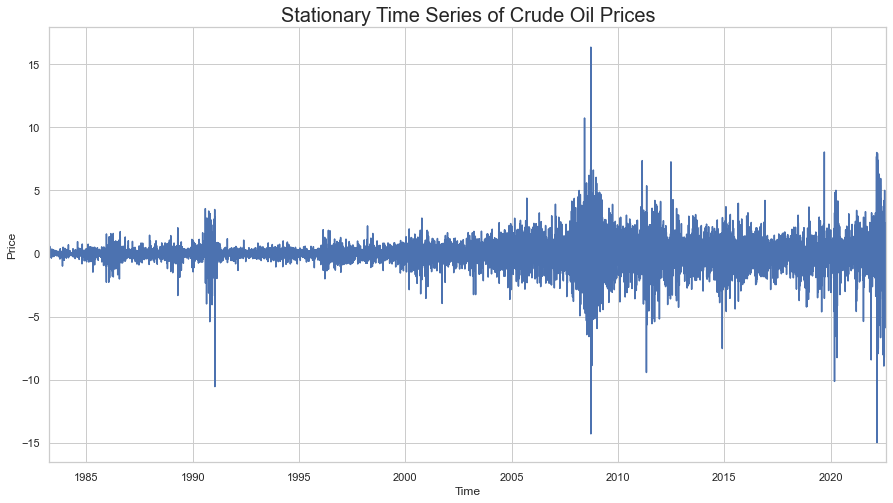

In [100]:
df_stat.plot(kind="line")
plt.title("Stationary Time Series of Crude Oil Prices", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Price");

#### Lets take a look at the ACF AND PACF plots neccesary for determing our model order

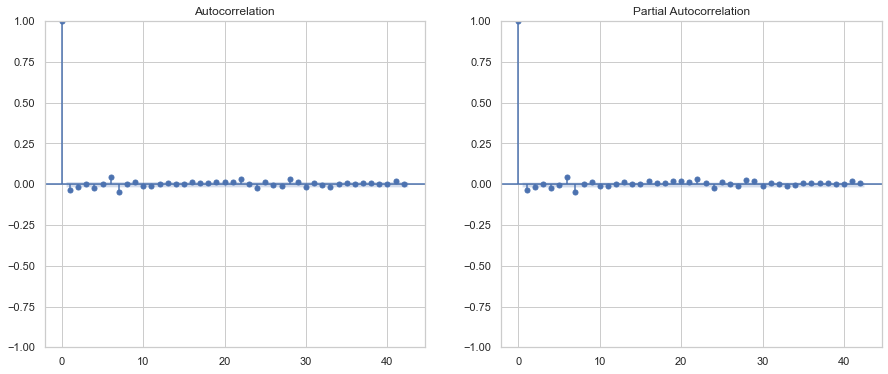

In [101]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
fig=plot_acf(df_stat,ax=ax[0])
fig=plot_pacf(df_stat,ax=ax[1])

#### Spliting of data

In [103]:
cutoff=int(len(df1["oil_price"])*0.95)
train=df1["oil_price"].iloc[:cutoff]
test=df1["oil_price"].iloc[cutoff:]
print("Shape of Training Data :", train.shape)
print("Shape of Test Data :", test.shape)

Shape of Training Data : (13661,)
Shape of Test Data : (719,)


#### Lets Tune our parameters in order to get the best order(one with the least MAE) to be used for final model

In [104]:
p_params=range(0,3,1)
q_params=range(0,3,1)

In [119]:
mae_grid={}
for p in p_params:
    mae_grid[p]=[]
    for q in q_params:
        order=(p,1,q)
        start_time=time.time()
        model2=ARIMA(train,order=order).fit()
        end_time=round(time.time()-start_time,2)
        print(f" Trained Model {order} in {end_time} seconds")
        pred1=model2.predict()
        mae=mean_absolute_error(train,pred1)
        mae_grid[p].append(mae)
        
print()
print(mae_grid)

 Trained Model (0, 1, 0) in 0.45 seconds
 Trained Model (0, 1, 1) in 1.09 seconds
 Trained Model (0, 1, 2) in 1.33 seconds
 Trained Model (1, 1, 0) in 0.75 seconds
 Trained Model (1, 1, 1) in 1.15 seconds
 Trained Model (1, 1, 2) in 4.35 seconds
 Trained Model (2, 1, 0) in 1.06 seconds
 Trained Model (2, 1, 1) in 6.87 seconds
 Trained Model (2, 1, 2) in 7.51 seconds

{0: [0.4687372813117633, 0.4733650171140199, 0.47400883685046735], 1: [0.4730377542562405, 0.4738624741294238, 0.4746002639319299], 2: [0.4740714494404798, 0.4747844724833868, 0.48012358375927794]}


In [120]:
mae_df=pd.DataFrame(mae_grid)
mae_df.round(4)

0       1       2
0  0.4687  0.4730  0.4741
1  0.4734  0.4739  0.4748
2  0.4740  0.4746  0.4801

In [121]:
mae_df.min()

0    0.468737
1    0.473038
2    0.474071
dtype: float64

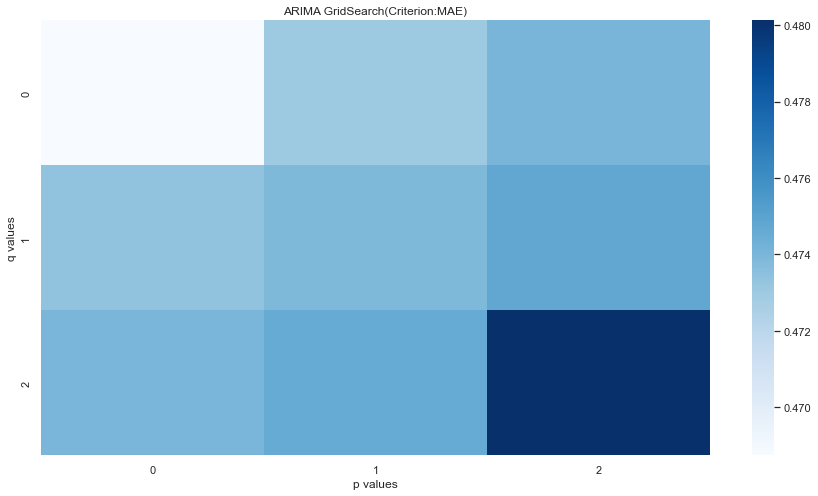

In [122]:
sns.heatmap(mae_df,cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA GridSearch(Criterion:MAE)");

##### From the above analysis, the order of our best Model in terms of MAE and computational time is 1,1,1. I chose this in favour of 0,1,0 (Random Walk) as i intend on bullding a general model that can be used for future predictions of more than one day , rather than a Naive Forecast.


#### Lets Build our model now, using the best order we've determined.¶

In [175]:
best_order=(1,1,2)

In [176]:
best_model=ARIMA(train,order=best_order).fit()

In [177]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              oil_price   No. Observations:                13661
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -18207.010
Date:                Sun, 28 Aug 2022   AIC                          36422.021
Time:                        09:49:44   BIC                          36452.110
Sample:                    04-04-1983   HQIC                         36432.050
                         - 08-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4676      0.293     -1.594      0.111      -1.042       0.107
ma.L1          0.4152      0.294      1.413      0.158      -0.161       0.991
ma.L2         -0.0354      0.014     -2.569      0.010      -0.062      -0.008
sigma2         0.8418      0.003    292.568      0.000       0.836       0.847
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            382636.44
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.30   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

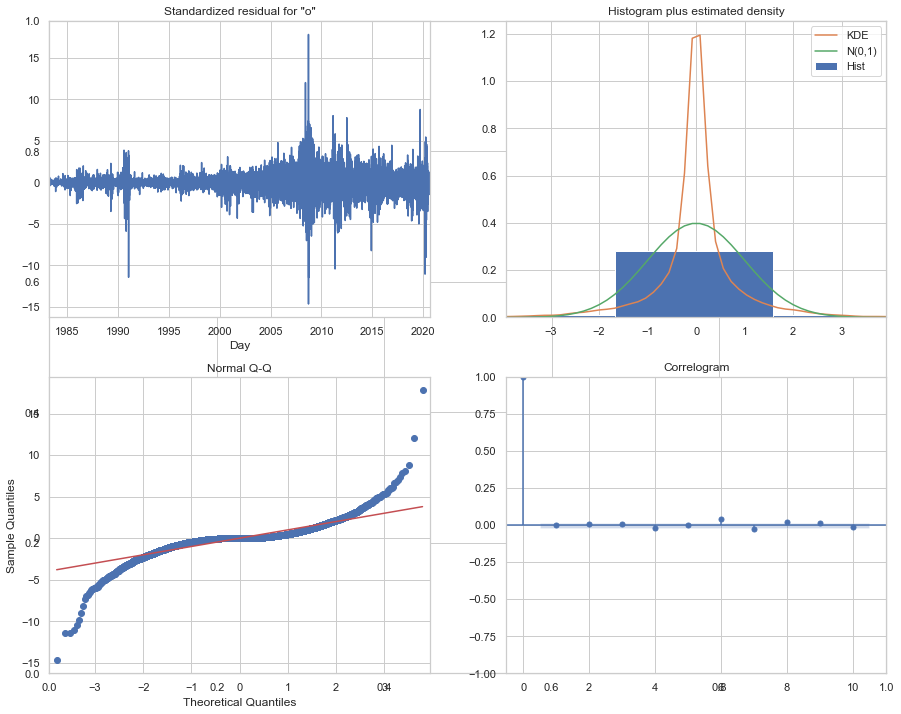

In [178]:
fig,ax=plt.subplots(figsize=(15,12))
best_model.plot_diagnostics(fig=fig);

The plot diagnostics reveal the following information :
- Top left : The Residual errors seems to flunctuate around a mean of zero
- Top Right : The density plot shows normal distribution with mean zero
- Bottom Left : All the dots should fall perfectly in line with the red line. Any nsignificant deviations would imply the distribution is skewed, hence ours is skewed.
- Bottom Right : The correlogram(ACF plot) shows that the Residual errors are not correlated.

#### Lets see how our model is performing on our train set

In [179]:
fitted_values=best_model.fittedvalues

In [180]:
mean_squared_error(train, fitted_values)

0.9052471158556142

In [181]:
mean_absolute_error(train, fitted_values)

0.4746002639319299

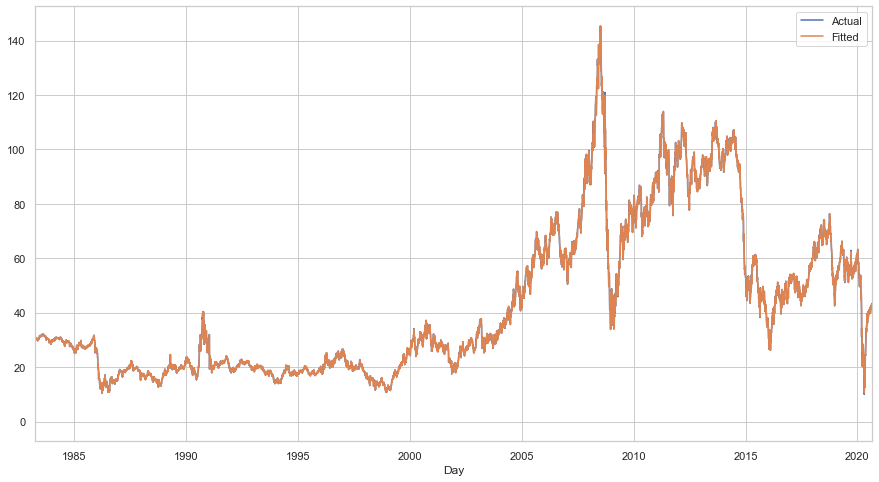

In [182]:
fig,ax=plt.subplots(figsize=(15,8))
train.plot(kind="line",ax=ax, label="Actual")
fitted_values.plot(kind="line",ax=ax, label="Fitted")
plt.legend();

- The almost coincided plot of our predictions on the catual data shows that we have a good Model.

#### Next, we would Implement Walk Forward Validation to Forecast predictions on our test set

In [183]:
start_time=time.time()
train_pred_wfv=pd.Series()
history=train.copy()
for i in range(len(test)):
    model1=ARIMA(history, order=best_order).fit()
    next_pred=model1.forecast()
    train_pred_wfv=train_pred_wfv.append(next_pred)
    history=history.append(test[next_pred.index])
    
end_time=round(time.time()-start_time,2)
print(f" Trained Model in {end_time} seconds")
train_pred_wfv.name="Prediction"
train_pred_wfv.index.name="Day"
train_pred_wfv.head()

 Trained Model in 3134.58 seconds


Day
2020-08-28    43.060004
2020-08-29    42.977375
2020-08-30    42.970127
2020-08-31    42.970209
2020-09-01    42.628787
Freq: D, Name: Prediction, dtype: float64

#### Save Model

In [189]:
import pickle
with open("ARIMA-model(Oil)", "wb") as f :
    pickle.dump(model1, f)
print("Model Saved")

Model Saved


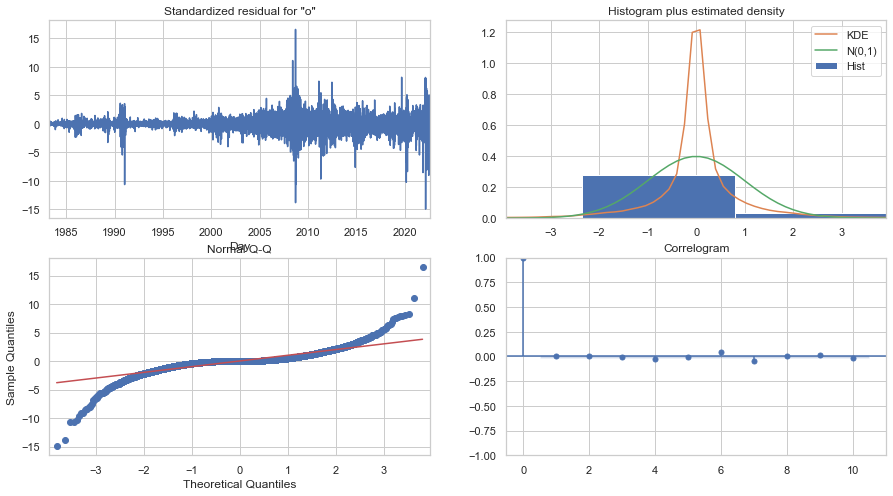

In [184]:
model1.plot_diagnostics(figsize=(15,8))
plt.show()

#### Creating a dataframe of the actual prices and our predicted prices

In [188]:
df_pred_test=pd.DataFrame(
    {"Actual" :test, "Forecast" : round(train_pred_wfv,2)}, index=test.index
)
df_pred_test.tail(10)

Actual  Forecast
Day                         
2022-08-07   89.01     89.00
2022-08-08   90.76     89.01
2022-08-09   90.50     90.69
2022-08-10   91.93     90.47
2022-08-11   94.34     91.89
2022-08-12   92.09     94.21
2022-08-13   92.09     92.14
2022-08-14   92.09     92.14
2022-08-15   89.41     92.08
2022-08-16   86.53     89.52

#### Visualising our Newly Created Dataframe

In [186]:
import plotly.express as px
fig=px.line(df_pred_test, labels={"value":"Crude Oil Price"})
fig.update_layout(
    title="Time Series of Crude Oil Prices - Actual vs Forecast",
    xaxis_title="Date",
    yaxis_title="Price"
)
fig.show()

- As seen in the plot above, our predicted values nearly coincide with the actual values, meaning our model did well in Forecasting.

#### Next, lets Evaluate our model using the below performance metrics

In [187]:
mse=mean_squared_error(test,train_pred_wfv)
print("MSE: "+str(mse))
mae=mean_absolute_error(test,train_pred_wfv)
print("MAE: "+str(mae))
rmse=math.sqrt(mean_squared_error(test,train_pred_wfv))
print("RMSE: "+str(rmse))
mape=mean_absolute_percentage_error(test,train_pred_wfv)
print("MAPE: "+str(mape))

MSE: 3.4747606151159265
MAE: 1.045654341405841
RMSE: 1.8640709790981476
MAPE: 0.013643287846148927


### With a Mean absolute Percentage Error(MAPE) of about 0.013, we can say our model performed great, having an estimated accuracy of about 98.7%¶